In [9]:
from helper import infer_independent
import calibr8
import numpy
import pandas
import pathlib
import matplotlib.cm
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.ticker as ticker

# Model creation

C:\Users\steier\AppData\Local\Continuum\miniconda3\envs\Amplify\lib\site-packages\calibr8\utils.py:526: UserWarning: Scale/sigma degree >= 2 is quite unusual. Consider a lower value.
  warnings.warn("Scale/sigma degree >= 2 is quite unusual. Consider a lower value.", UserWarning)


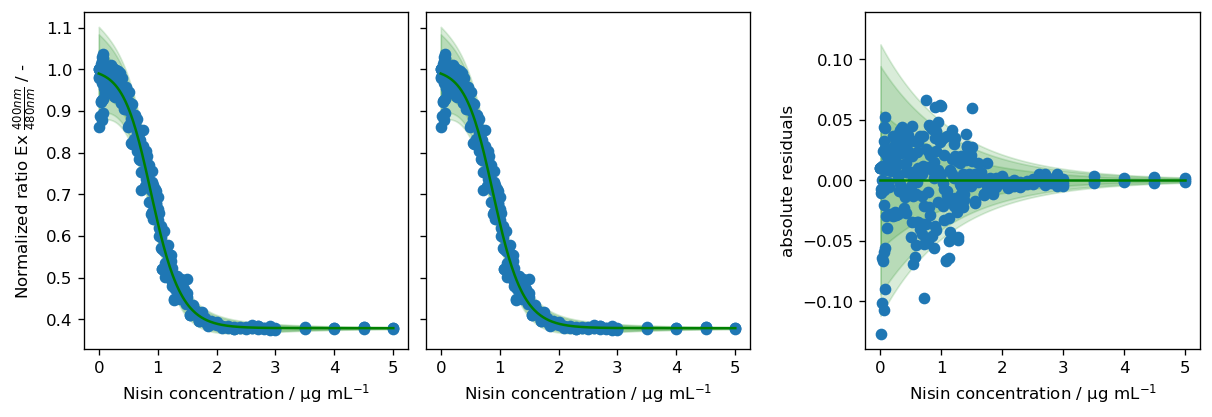

In [3]:
# Define model class
class NisinCalibrationModel(calibr8.BaseAsymmetricLogisticN):
    def __init__(
        self,
        *,
        independent_key: str="Nisin concentration / µg mL$^{-1}$",
        dependent_key: str=r"Normalized ratio Ex $\frac{400 nm}{480 nm}$ / -",
        sigma_degree: int=2, # this is just a helper to allow for the exponential sigma
        theta_names= tuple("L_L,L_U,I_x,S,c,I_sigma,L_sigma,k_sigma".split(",")),
    ):
        super().__init__(
            independent_key=independent_key,
            dependent_key=dependent_key,
            sigma_degree=sigma_degree,
            theta_names=theta_names,
        )
    def predict_dependent(self, x, *, theta=None):
        """Predicts the parameters mu and sigma of a normal distribution which
        characterizes the dependent variable given values of the independent variable.

        Parameters
        ----------
        x : array-like
            values of the independent variable
        theta : optional, array-like
            parameter vector of the calibration model:
                5 parameters of asymmetric logistic model for mu
                [sigma_degree] parameters for sigma (lowest degree first)

        Returns
        -------
        mu : array-like
            values for the mu parameter of a normal distribution describing the dependent variable
        sigma : array-like or float
            values for the sigma parameter of a normal distribution describing the dependent variable
        """
        if theta is None:
            theta = self.theta_fitted
        mu = calibr8.asymmetric_logistic(x, theta[:5])
        if self.sigma_degree == 0:
            sigma = theta[-1]
        else:
            sigma = calibr8.exponential(x, theta[5:])
        return mu, sigma


# Load your dataset
df_data = pandas.read_excel("calibration data.xlsx")
cal_independent = df_data["Concentration [µg/mL]"]
cal_dependent = df_data["normalized fluorescence ratio"]

# Fit the model
Pahpshmirmodel = NisinCalibrationModel()
calibr8.fit_scipy(
    Pahpshmirmodel,
    independent=cal_independent.to_numpy(),
    dependent=cal_dependent.to_numpy(),
    theta_guess=[0.3, 1.05, 1.0, -1.0, 0.1, 0.3, 0.01, 0.8],
    theta_bounds=[
        (0.2, 0.5),
        (0.8, 1.2),
        (0.0, 2.0),
        (-2.0, 0),
        (-1.0, 1.0),
        (0.00001, 0.5),
        (0.00001, 0.2),
        (0.01, 2),
    ],
)

# Plot the residuals
fig, axs = calibr8.plot_model(Pahpshmirmodel)

# Nisin inference

## Data import

In [24]:
#import raw data
sample_list = pandas.read_excel(pathlib.Path('raw data inference.xlsx'), header=0,index_col=[0,1])

In [25]:
#generate list containing used dilution factors
df_list = sample_list.columns
df_list = df_list.to_numpy()

In [10]:
#calculation of probability density function (PDF) of nisin concentration based on readouts and dilution factors

df_hdi_x = pandas.DataFrame()
df_hdi_pdf = pandas.DataFrame()
df_median = pandas.DataFrame()

for row, i in sample_list.iterrows():
    posterior = infer_independent(
        model= Pahpshmirmodel,
        d=df_list,
        y=i,
        lower=0,
        upper=20,
        ci_prob=0.999,
    )
    hdi_x = pandas.DataFrame()
    hdi_pdf = pandas.DataFrame()
    median= pandas.DataFrame(index=['median'])
    hdi_x[''+ str(row)+''] = posterior.hdi_x
    hdi_pdf[''+ str(row)+''] = posterior.hdi_pdf
    median[''+ str(row)+''] = posterior.median
    df_median = pandas.concat([df_median,median],axis=1)
    df_hdi_pdf = pandas.concat([df_hdi_pdf,hdi_pdf],axis=1)
    df_hdi_x = pandas.concat([df_hdi_x,hdi_x],axis=1)

In [11]:
#transposing dataframes containing parameters of calculated PDF
df_hdi_pdf_tp = df_hdi_pdf.transpose()
df_hdi_x_tp = df_hdi_x.transpose()
df_median_tp = df_median.transpose()

In [12]:
#calculation of credible intervals (CIs) based on min and max values of PDF

hdi_x_min = pandas.DataFrame()
hdi_x_max = pandas.DataFrame()

for row, i in df_hdi_x_tp.iterrows():
    row_hdi_max = pandas.DataFrame(index=['hdi_max'])
    row_hdi_max[''+ str(row)+''] = i.max()
    hdi_x_max = pandas.concat([hdi_x_max,row_hdi_max],axis=1)
    row_hdi_min = pandas.DataFrame(index=['hdi_min'])
    row_hdi_min[''+ str(row)+''] = i.min()
    hdi_x_min = pandas.concat([hdi_x_min,row_hdi_min],axis=1)

In [13]:
#formatting of credible intervals

hdi_x_min_tp = hdi_x_min.transpose()
hdi_x_max_tp = hdi_x_max.transpose()

In [14]:
#joining dataframes

df_median_min = pandas.concat([df_median_tp,hdi_x_min_tp], axis=1)
df_median_min_max = pandas.concat([df_median_min,hdi_x_max_tp], axis=1)

In [15]:
#calculating CIs

df_median_min_max['y_err_min'] = df_median_min_max['median'].sub(df_median_min_max['hdi_min'])
df_median_min_max['y_err_max'] = df_median_min_max['hdi_max'].sub(df_median_min_max['median'])

df_median_min_max['Label'] = df_median_min_max.index

In [16]:
#sorting of dataframe

df_median_min_max_sorted_index = df_median_min_max.sort_index()

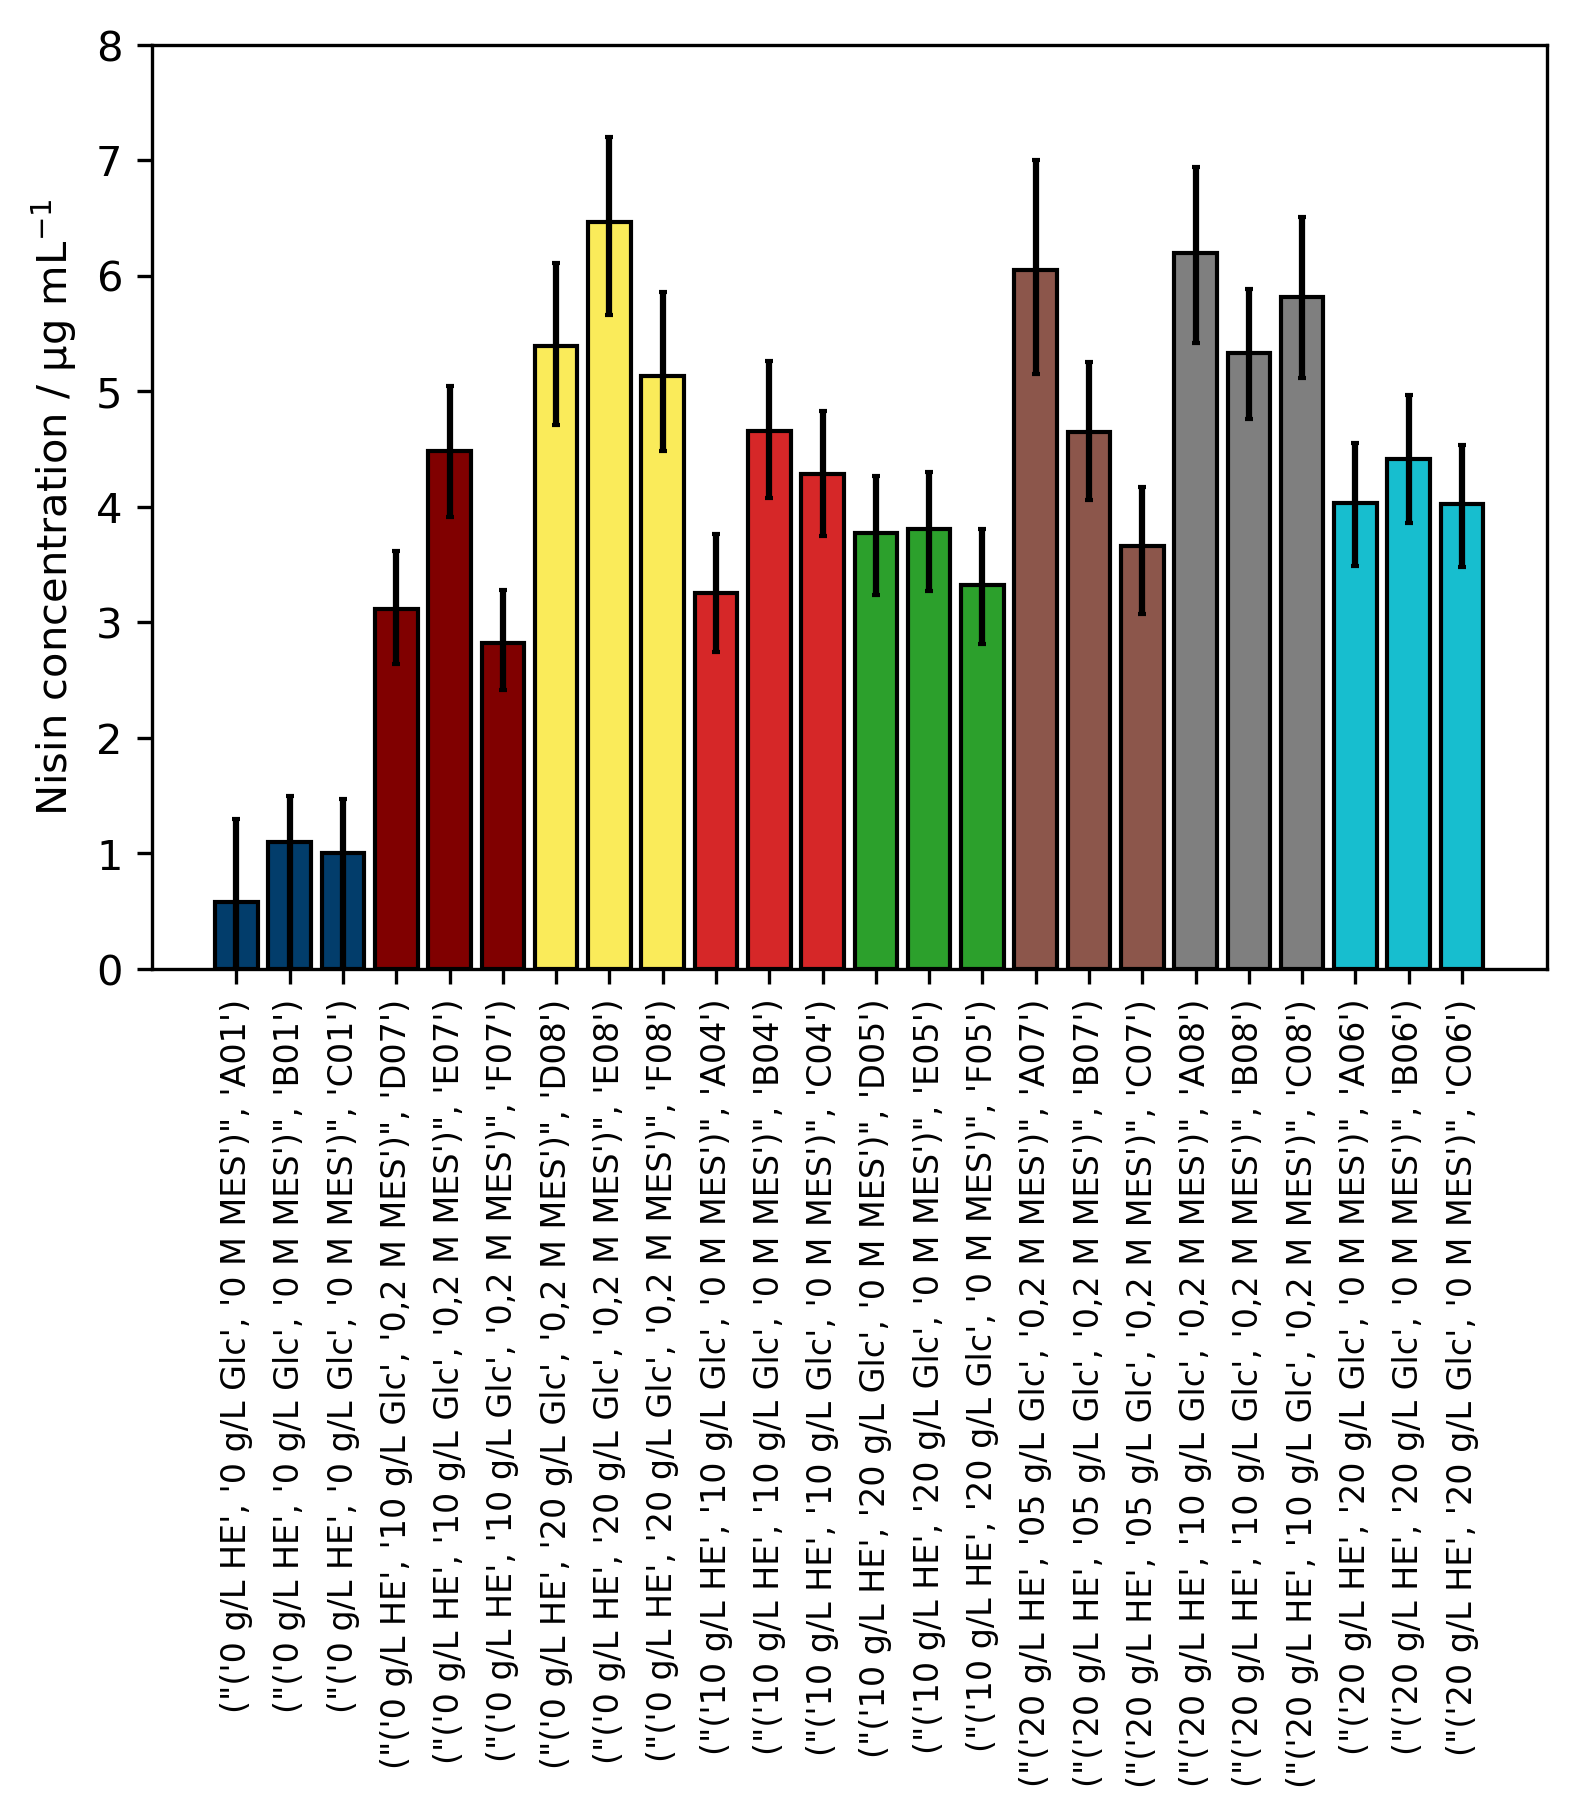

In [23]:
#visualisation

fig, ax = plt.subplots(figsize=(6,4),dpi=300)

color = ['#023d6b','#023d6b','#023d6b','maroon','maroon','maroon','#faeb5a','#faeb5a','#faeb5a',
         'tab:red','tab:red','tab:red','tab:green','tab:green','tab:green','tab:brown','tab:brown','tab:brown',
         'tab:gray','tab:gray','tab:gray','tab:cyan','tab:cyan','tab:cyan']

x=numpy.arange(len(df_median_min_max_sorted_index))

ax.bar(x, df_median_min_max_sorted_index['median'], yerr=[df_median_min_max_sorted_index['y_err_min'],df_median_min_max_sorted_index['y_err_max']], capsize=1, edgecolor='black', color=color)
ax.set_ylim(0, 8)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_ylabel('Nisin concentration / µg mL$^{-1}$')

ax.set_xticks(x)
ax.set_xticklabels(df_median_min_max_sorted_index['Label'], rotation=90,
                     fontdict = {'fontsize': 8})

pyplot.show()